In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler,MinMaxScaler,FunctionTransformer
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble.partial_dependence import plot_partial_dependence
warnings.filterwarnings('ignore')

In [2]:
ds_borrower = pd.read_csv(r'C:\Users\jainn4\Downloads\challenge-customer-data-science-master\data\ds-borrower.csv',delim_whitespace=True,names=['CustId','YrsEmp','YrsRes','Age','RentOrHome','TypeCurEmp','Dep'],header=0)
ds_app = pd.read_table(r'C:\Users\jainn4\Downloads\challenge-customer-data-science-master\data\ds-app.tsv',delim_whitespace=True,names=['CustId','LoanPayPer','LoanReason','Amt_Req','IR','Co-App'])
ds_credit = pd.read_table(r'C:\Users\jainn4\Downloads\challenge-customer-data-science-master\data\ds-credit.tsv',delim_whitespace=True,names=['CustId','ChkAcctBal','DebtsPaid','SavAcctBal','LoanAppOpen'])
ds_result = pd.read_table(r'C:\Users\jainn4\Downloads\challenge-customer-data-science-master\data\ds-result.tsv',delim_whitespace=True,names=['CustId','LoanApproved'])

In [3]:
ds_borrower.shape,ds_app.shape,ds_credit.shape,ds_result.shape

((750, 7), (748, 6), (749, 5), (1502, 2))

In [4]:
print(ds_borrower[ds_borrower['CustId'] == 'Emp'])
print(ds_result[ds_result['CustId'] == '(749'])
print(ds_result[ds_result['CustId'] == 'CustomerID'])

    CustId YrsEmp YrsRes   Age RentOrHome TypeCurEmp  Dep
192    Emp    Mvd    Age  Home     CurEmp        Dep  NaN
     CustId LoanApproved
1501   (749        rows)
         CustId        LoanApproved
750  CustomerID  WasTheLoanApproved


In [5]:
ds_borrower.drop(192,inplace=True)
ds_result.drop([1501,750],inplace=True)

In [6]:
ds_borrower.CustId = ds_borrower.CustId.astype('int64')
ds_result.CustId = ds_result.CustId.astype('int64')

In [7]:
ds_borrower.shape,ds_app.shape,ds_credit.shape,ds_result.shape

((749, 7), (748, 6), (749, 5), (1500, 2))

In [8]:
ds_combined = pd.merge(pd.merge(pd.merge(ds_borrower,ds_app,on='CustId',how='outer'),ds_credit,on='CustId',how='outer'),ds_result,on='CustId',how='outer').drop_duplicates()

In [9]:
ds_combined.shape

(849, 17)

In [10]:
ds_combined.head(10)

,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
0,765,1,1,46,rent,skilled,1.0,15.0,goods,1845.0,4.0,guarant,debt,paid,some,1.0,NaN
1,668,4,4,49,owned,skilled,1.0,12.0,goods,1092.0,4.0,guarant,some,paid,some,2.0,Y
3,68,10+,4,57,rent,skilled,1.0,30.0,goods,3622.0,4.0,none,debt,paid,v.high,2.0,Y
5,805,4,2,41,owned,skilled,1.0,6.0,goods,2116.0,2.0,none,NaN,NaN,NaN,NaN,NaN
6,495,7,4,24,rent,skilled,1.0,30.0,auto,6187.0,1.0,none,NaN,NaN,NaN,NaN,Y
8,709,10+,4,29,rent,skilled,1.0,45.0,busin,11816.0,2.0,none,debt,paid,some,2.0,N
10,641,4,4,50,free,skilled,1.0,36.0,goods,2671.0,4.0,co-app,some,paid,medium,1.0,N
12,268,10+,1,45,owned,skilled,1.0,24.0,auto,2303.0,4.0,co-app,debt,paid,some,1.0,N
14,652,10+,3,50,owned,skilled,1.0,12.0,auto,2390.0,4.0,none,none,paid,none,1.0,Y
16,236,7,3,36,owned,skilled,1.0,30.0,goods,6742.0,2.0,none,none,delayed,none,2.0,Y


In [11]:
# LoanApproved is either 'Y' or 'N'.
ds_final = ds_combined[ds_combined['LoanApproved'].notnull()]
# LoanApproved is NaN.
ds_unused = ds_combined[ds_combined['LoanApproved'].isnull()] 

In [12]:
ds_final.shape,ds_unused.shape

((750, 17), (99, 17))

In [13]:
ds_final.head()

,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
1,668,4,4,49,owned,skilled,1.0,12.0,goods,1092.0,4.0,guarant,some,paid,some,2.0,Y
3,68,10+,4,57,rent,skilled,1.0,30.0,goods,3622.0,4.0,none,debt,paid,v.high,2.0,Y
6,495,7,4,24,rent,skilled,1.0,30.0,auto,6187.0,1.0,none,NaN,NaN,NaN,NaN,Y
8,709,10+,4,29,rent,skilled,1.0,45.0,busin,11816.0,2.0,none,debt,paid,some,2.0,N
10,641,4,4,50,free,skilled,1.0,36.0,goods,2671.0,4.0,co-app,some,paid,medium,1.0,N


In [14]:
ds_final['YrsEmp'] = ds_final['YrsEmp'].str.replace('+','')

In [15]:
ds_final['LoanApproved'].value_counts()

Y    515
N    233
1      2
Name: LoanApproved, dtype: int64

In [16]:
ds_final[ds_final.LoanApproved =='1']

,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
986,278,0,4,27,owned,skilled,1.0,45.0,auto,4576.0,3.0,none,some,delayed,medium,1.0,1
1132,747,1,4,41,owned,unskill,2.0,NaN,NaN,NaN,NaN,NaN,debt,paid,some,1.0,1


In [17]:
ds_final['LoanApproved'] = ds_final['LoanApproved'].str.replace('1','Y')

In [18]:
ds_final['LoanApproved'].value_counts()

Y    517
N    233
Name: LoanApproved, dtype: int64

In [19]:
# Check both the datatypes and if there are missing values print(f"Data types:\n{11 * '-'}")
print(f"{ds_final.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{ds_final.isnull().sum()}")
ds_final.head()

CustId            int64
YrsEmp           object
YrsRes           object
Age              object
RentOrHome       object
TypeCurEmp       object
Dep             float64
LoanPayPer      float64
LoanReason       object
Amt_Req         float64
IR              float64
Co-App           object
ChkAcctBal       object
DebtsPaid        object
SavAcctBal       object
LoanAppOpen     float64
LoanApproved     object
dtype: object

Sum of null values in each feature:
-----------------------------------
CustId           0
YrsEmp          91
YrsRes          91
Age             91
RentOrHome      91
TypeCurEmp      91
Dep             91
LoanPayPer      87
LoanReason      87
Amt_Req         87
IR              87
Co-App          87
ChkAcctBal      90
DebtsPaid       90
SavAcctBal      90
LoanAppOpen     90
LoanApproved     0
dtype: int64


,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
1,668,4,4,49,owned,skilled,1.0,12.0,goods,1092.0,4.0,guarant,some,paid,some,2.0,Y
3,68,10,4,57,rent,skilled,1.0,30.0,goods,3622.0,4.0,none,debt,paid,v.high,2.0,Y
6,495,7,4,24,rent,skilled,1.0,30.0,auto,6187.0,1.0,none,NaN,NaN,NaN,NaN,Y
8,709,10,4,29,rent,skilled,1.0,45.0,busin,11816.0,2.0,none,debt,paid,some,2.0,N
10,641,4,4,50,free,skilled,1.0,36.0,goods,2671.0,4.0,co-app,some,paid,medium,1.0,N


Positive examples = 517
Negative examples = 233
Proportion of positive to negative examples = 2.22%


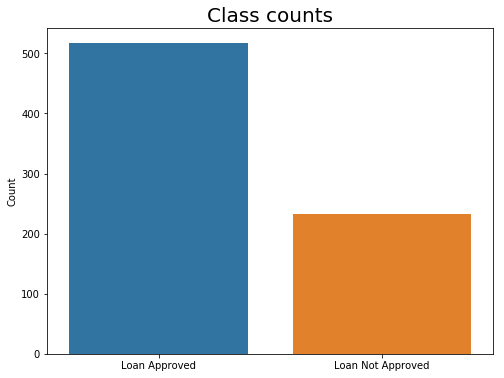

In [20]:
# Get number of positve and negative examples
pos = ds_final[ds_final["LoanApproved"] == 'Y'].shape[0]
neg = ds_final[ds_final["LoanApproved"] == 'N'].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 1:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(ds_final["LoanApproved"])
plt.xticks((0, 1), ["Loan Approved", "Loan Not Approved"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [21]:
# Replacing with mode
imputer = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
var_mod = ['YrsRes','YrsEmp','Age','Dep','IR','LoanAppOpen']
for i in var_mod:
    ds_final[[i]] = imputer.fit_transform(ds_final[[i]])

In [22]:
# Replacing with median
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
ds_final[['LoanPayPer']] = imputer.fit_transform(ds_final[['LoanPayPer']])

In [23]:
# Replacing with mean
imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
ds_final[['Amt_Req']] = imputer.fit_transform(ds_final[['Amt_Req']])

In [24]:
# Check both the datatypes and if there are missing values print(f"Data types:\n{11 * '-'}")
print(f"{ds_final.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{ds_final.isnull().sum()}")
ds_final.head()

CustId            int64
YrsEmp          float64
YrsRes          float64
Age             float64
RentOrHome       object
TypeCurEmp       object
Dep             float64
LoanPayPer      float64
LoanReason       object
Amt_Req         float64
IR              float64
Co-App           object
ChkAcctBal       object
DebtsPaid        object
SavAcctBal       object
LoanAppOpen     float64
LoanApproved     object
dtype: object

Sum of null values in each feature:
-----------------------------------
CustId           0
YrsEmp           0
YrsRes           0
Age              0
RentOrHome      91
TypeCurEmp      91
Dep              0
LoanPayPer       0
LoanReason      87
Amt_Req          0
IR               0
Co-App          87
ChkAcctBal      90
DebtsPaid       90
SavAcctBal      90
LoanAppOpen      0
LoanApproved     0
dtype: int64


,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
1,668,4.0,4.0,49.0,owned,skilled,1.0,12.0,goods,1092.0,4.0,guarant,some,paid,some,2.0,Y
3,68,10.0,4.0,57.0,rent,skilled,1.0,30.0,goods,3622.0,4.0,none,debt,paid,v.high,2.0,Y
6,495,7.0,4.0,24.0,rent,skilled,1.0,30.0,auto,6187.0,1.0,none,NaN,NaN,NaN,1.0,Y
8,709,10.0,4.0,29.0,rent,skilled,1.0,45.0,busin,11816.0,2.0,none,debt,paid,some,2.0,N
10,641,4.0,4.0,50.0,free,skilled,1.0,36.0,goods,2671.0,4.0,co-app,some,paid,medium,1.0,N


In [25]:
ds_final['RentOrHome'].fillna(ds_final['RentOrHome'].mode()[0], inplace=True)
ds_final['TypeCurEmp'].fillna(ds_final['TypeCurEmp'].mode()[0], inplace=True)
ds_final['LoanReason'].fillna(ds_final['LoanReason'].mode()[0], inplace=True)
ds_final['Co-App'].fillna(ds_final['Co-App'].mode()[0], inplace=True)
ds_final['ChkAcctBal'].fillna(ds_final['ChkAcctBal'].mode()[0], inplace=True)
ds_final['DebtsPaid'].fillna(ds_final['DebtsPaid'].mode()[0], inplace=True)
ds_final['SavAcctBal'].fillna(ds_final['SavAcctBal'].mode()[0], inplace=True)

In [26]:
var_mod = ['RentOrHome','TypeCurEmp','LoanReason','Co-App','ChkAcctBal','DebtsPaid','SavAcctBal','YrsEmp','YrsRes','Dep','IR','LoanAppOpen','LoanApproved']
for i in var_mod:
    ds_final[i] = ds_final[i].astype('category').cat.codes

In [27]:
# Check both the datatypes and if there are missing values print(f"Data types:\n{11 * '-'}")
print(f"{ds_final.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{ds_final.isnull().sum()}")
ds_final.head()

CustId            int64
YrsEmp             int8
YrsRes             int8
Age             float64
RentOrHome         int8
TypeCurEmp         int8
Dep                int8
LoanPayPer      float64
LoanReason         int8
Amt_Req         float64
IR                 int8
Co-App             int8
ChkAcctBal         int8
DebtsPaid          int8
SavAcctBal         int8
LoanAppOpen        int8
LoanApproved       int8
dtype: object

Sum of null values in each feature:
-----------------------------------
CustId          0
YrsEmp          0
YrsRes          0
Age             0
RentOrHome      0
TypeCurEmp      0
Dep             0
LoanPayPer      0
LoanReason      0
Amt_Req         0
IR              0
Co-App          0
ChkAcctBal      0
DebtsPaid       0
SavAcctBal      0
LoanAppOpen     0
LoanApproved    0
dtype: int64


,CustId,YrsEmp,YrsRes,Age,RentOrHome,TypeCurEmp,Dep,LoanPayPer,LoanReason,Amt_Req,IR,Co-App,ChkAcctBal,DebtsPaid,SavAcctBal,LoanAppOpen,LoanApproved
1,668,2,3,49.0,1,2,0,12.0,2,1092.0,3,1,3,1,3,1,1
3,68,4,3,57.0,2,2,0,30.0,2,3622.0,3,2,0,1,4,1,1
6,495,3,3,24.0,2,2,0,30.0,0,6187.0,0,2,2,1,3,0,1
8,709,4,3,29.0,2,2,0,45.0,1,11816.0,1,2,0,1,3,1,0
10,641,2,3,50.0,0,2,0,36.0,2,2671.0,3,0,3,1,1,0,0


In [28]:
X = ds_final.loc[:,'YrsEmp':'LoanAppOpen']
Y = ds_final.loc[:,'LoanApproved']
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=7)

In [29]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500, max_features=0.10,
                                criterion="gini")
# Build base line model.
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Baseline model's average AUC: {scores.mean():.3f}")


Baseline model's average AUC: 0.707


In [30]:
svm_clf = SVC(gamma=0.1,
              C=0.01,
              kernel="poly",
              degree=3,
              coef0=10.0,
              probability=True)
# Build base line model.
pip_baseline = make_pipeline(RobustScaler(), svm_clf)
scores = cross_val_score(pip_baseline,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SVM model's average AUC: {scores.mean():.3f}")

SVM model's average AUC: 0.669


In [52]:
logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
# Build base line model.
pip_baseline = make_pipeline(RobustScaler(), logreg_clf)
scores_lr = cross_val_score(pip_baseline,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Logistic Regression model's average AUC: {scores.mean():.3f}")

Logistic Regression model's average AUC: 0.663


In [32]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
pip_baseline = make_pipeline(RobustScaler(), gb_clf)
scores = cross_val_score(pip_baseline,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Gradient Boosting model's average AUC: {scores.mean():.3f}")

Gradient Boosting model's average AUC: 0.693


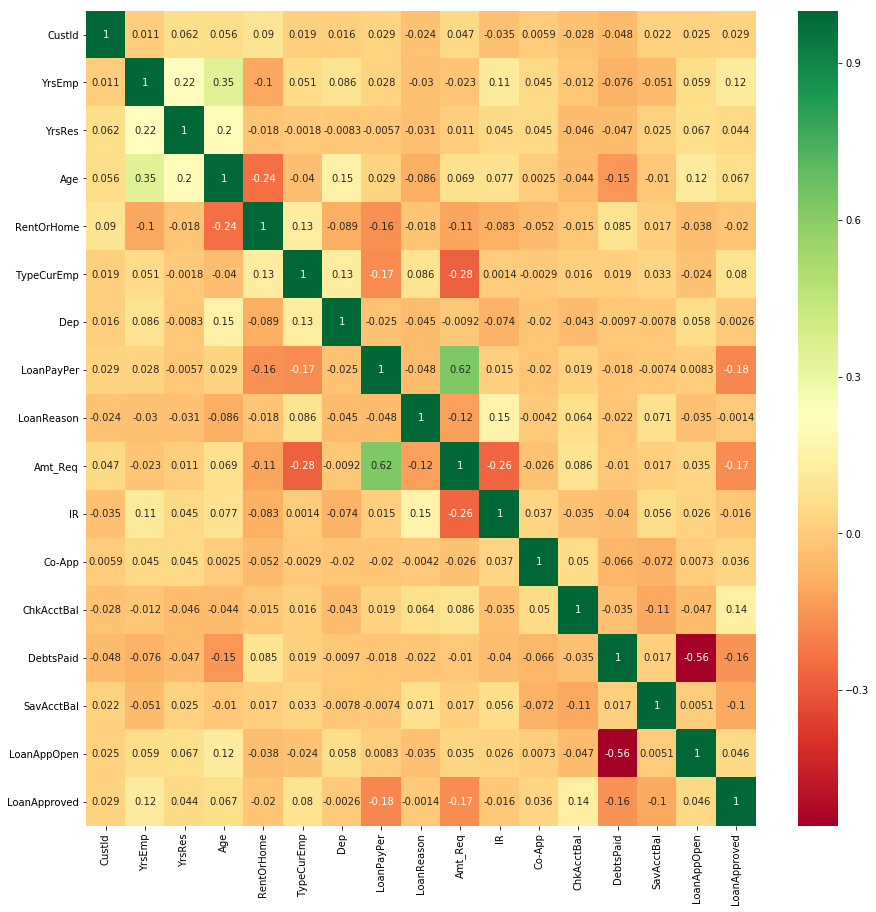

In [75]:
#get correlations of each features in dataset
corrmat = ds_final.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(ds_final[top_corr_features].corr(),annot=True,cmap="RdYlGn")

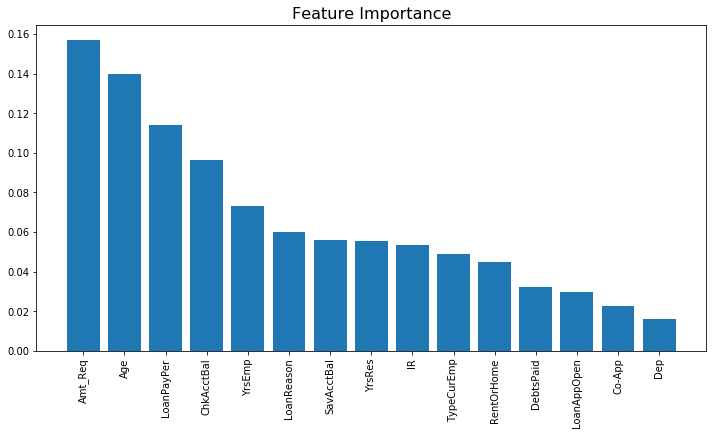

In [85]:
# fit RF to plot feature importances
rf_clf.fit(x_train, y_train)

# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]),X.columns[indices],
           rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

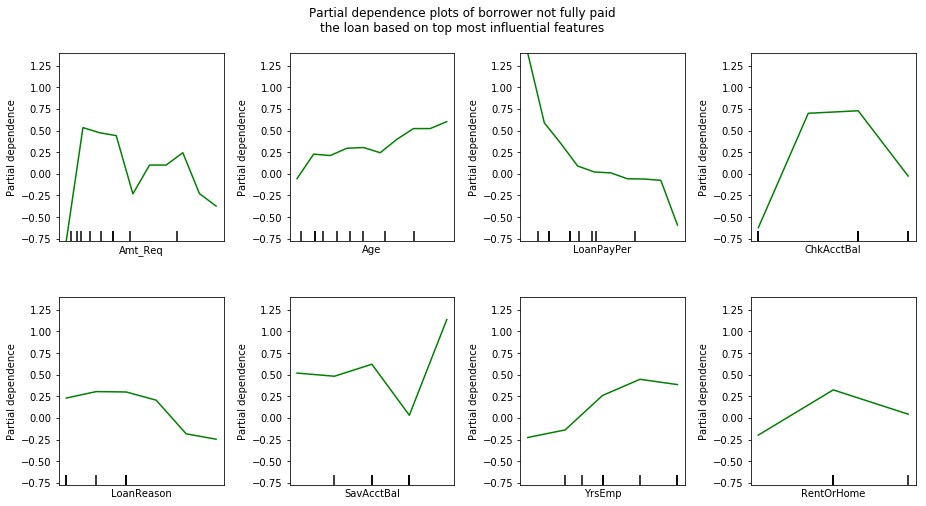

In [92]:
# Plot partial dependence plots
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(x_train, y_train)
fig, axes = plot_partial_dependence(gbrt,
                                    x_train,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=x_train.columns,
                                    figsize=(14, 8),
                                   grid_resolution=10)
plt.subplots_adjust(top=0.9)
plt.suptitle("Partial dependence plots of borrower not fully paid\n" + 
             "the loan based on top most influential features")
for ax in axes:
  ax.set_xticks(())

In [ ]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(penalty="l2", C=100, fit_intercept=True),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
]


# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    # Use CV to generate meta-features
    meta_features = cross_val_predict(model, x_train, y_train, cv=10)
    model.fit(meta_features, y_train) # train the model
#    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
# Impute the missing data using features means
'''imp = Imputer()
imp.fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

# Standardize the data
std = RobustScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_test = std.transform(x_test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)

# Shuffle the data
perms = np.random.permutation(x_train.shape[0])
x_train = x_train[perms]
y_train = y_train[perms]'''

# Define base learners
'''xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)'''
svm_clf = SVC(gamma=0.1,
              C=0.01,
              kernel="poly",
              degree=3,
              coef0=10.0,
              probability=True)
rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
# Fitting voting clf --> average ensemble
'''voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)'''

voting_clf = VotingClassifier([("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)

voting_clf.fit(x_train, y_train)
#xgb_model, svm_model, rf_model = voting_clf.estimators_
svm_model, rf_model = voting_clf.estimators_
'''models = {"xgb": xgb_model,
          "svm": svm_model,
          "rf": rf_model,
          "avg_ensemble": voting_clf}'''

models = {"svm": svm_model,
          "rf": rf_model,
          "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))

# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack, x_train, y_train, cv=10, method="transform")

# Refit the first stack on the full training set
first_stack.fit(x_train, y_train)

# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_train)

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
  model_probs = model.predict_proba(x_test)[:, 1:]
  model_auc_score = roc_auc_score(y_test, model_probs)
  fpr, tpr, _ = roc_curve(y_test, model_probs)
  precision, recall, _ = precision_recall_curve(y_test, model_probs)
  axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
  axes[1].plot(recall, precision, label=f"{name}")

stacked_probs = second_stack.predict_proba(first_stack.transform(x_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

In [702]:
# Create dummy variables from the features
ds_final1 = pd.get_dummies(ds_final, columns=['RentOrHome','TypeCurEmp','ChkAcctBal','LoanReason','Co-App','DebtsPaid','SavAcctBal'], drop_first=True)

In [703]:
ds_final1.head()

,CustId,YrsEmp,YrsRes,Age,Dep,LoanPayPer,Amt_Req,IR,LoanAppOpen,LoanApproved,...,LoanReason_other,LoanReason_repairs,LoanReason_school,Co-App_guarant,Co-App_none,DebtsPaid_paid,SavAcctBal_medium,SavAcctBal_none,SavAcctBal_some,SavAcctBal_v.high
1,668,4.0,4.0,49.0,1.0,12.0,1092.0,4.0,2.0,Y,...,0,0,0,1,0,1,0,0,1,0
3,68,10.0,4.0,57.0,1.0,30.0,3622.0,4.0,2.0,Y,...,0,0,0,0,1,1,0,0,0,1
6,495,7.0,4.0,24.0,1.0,30.0,6187.0,1.0,1.0,Y,...,0,0,0,0,1,1,0,0,1,0
8,709,10.0,4.0,29.0,1.0,45.0,11816.0,2.0,2.0,N,...,0,0,0,0,1,1,0,0,1,0
10,641,4.0,4.0,50.0,1.0,36.0,2671.0,4.0,1.0,N,...,0,0,0,0,0,1,1,0,0,0


In [704]:
# Check both the datatypes and if there are missing values print(f"Data types:\n{11 * '-'}")
print(f"{ds_final1.dtypes}\n")

CustId                   int64
YrsEmp                category
YrsRes                category
Age                    float64
Dep                   category
LoanPayPer             float64
Amt_Req                float64
IR                    category
LoanAppOpen           category
LoanApproved          category
RentOrHome_owned         uint8
RentOrHome_rent          uint8
TypeCurEmp_self          uint8
TypeCurEmp_skilled       uint8
TypeCurEmp_unskill       uint8
ChkAcctBal_high          uint8
ChkAcctBal_none          uint8
ChkAcctBal_some          uint8
LoanReason_busin         uint8
LoanReason_goods         uint8
LoanReason_other         uint8
LoanReason_repairs       uint8
LoanReason_school        uint8
Co-App_guarant           uint8
Co-App_none              uint8
DebtsPaid_paid           uint8
SavAcctBal_medium        uint8
SavAcctBal_none          uint8
SavAcctBal_some          uint8
SavAcctBal_v.high        uint8
dtype: object



In [418]:
ds_final['LoanApproved'] = ds_final['LoanApproved'].astype('category').cat.codes

In [419]:
ds_final.dtypes

CustId            int64
YrsEmp           object
YrsRes           object
Age              object
RentOrHome         int8
TypeCurEmp         int8
Dep             float64
LoanPayPer      float64
LoanReason         int8
Amt_Req         float64
IR              float64
Co-App             int8
ChkAcctBal         int8
DebtsPaid          int8
SavAcctBal         int8
LoanAppOpen     float64
LoanApproved       int8
dtype: object

In [420]:
ds_final['LoanAppOpen'].value_counts()

1.0    416
2.0    222
3.0     18
4.0      4
Name: LoanAppOpen, dtype: int64

In [ ]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Original model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(RobustScaler(),
                                    RandomUnderSampler(),
                                    rf_clf)
scores = cross_val_score(pip_undersample,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Under-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(RobustScaler(),
                                   RandomOverSampler(),
                                   rf_clf)
scores = cross_val_score(pip_oversample,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10,
                                         random_state=123)
pip_resampled = make_pipeline(RobustScaler(),
                              resampled_rf)
scores = cross_val_score(pip_resampled,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"EasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(RobustScaler(),
                              SMOTE(),
                              rf_clf)
scores = cross_val_score(pip_smote,
                         x_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SMOTE model's average AUC: {scores.mean():.3f}")
